**Construction Duration Estimation**

The code that this Jupyter Notebook contains is all and the only code used for completing this challenge. Thought the slides
are being used to summarize the key findings, this notebook contains a little more explanation on certain decisions made 
throughout the process.

This notebook follows code which aligns with industry/ production practices, any models, encoders and imputers in use are only being fit on the training data. Cross validation is being used wherever possible and model evaluation metrics are associated with the test set.

In [ ]:
"""
Notebook Created on Sunday, Jul 16 2023 at 16:50 PT

Author: Tanmay Birar

Purpose: Analyze a dataset to fit appropriate machine learning models and predict a continuous variable.
"""

**Loading Data and Libraries**

In [397]:
import os
import pandas as pd
import numpy as np

os.chdir("/Users/tanmaybirar/Downloads/Construction")

In [398]:
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80 !important; }</style>"))

In [399]:
whole_data = pd.read_csv("- Construction History.csv") #whole_data will be preserved in the original form
whole_data = whole_data.drop(columns='index')

In [531]:
whole_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   county               11999 non-null  object 
 1   latitude             12000 non-null  float64
 2   longitude            12000 non-null  float64
 3   service category     12000 non-null  object 
 4   project type         11976 non-null  object 
 5   parts                11998 non-null  object 
 6   material             11924 non-null  object 
 7   connector            11888 non-null  object 
 8   equipment            11894 non-null  object 
 9   land use             11975 non-null  object 
 10  stakeholder          11975 non-null  object 
 11  service provider     11975 non-null  object 
 12  budget               12000 non-null  int64  
 13  construction area    12000 non-null  float64
 14  load                 11945 non-null  object 
 15  KPI                  10308 non-null 

In [530]:
whole_data.head(5)

,county,latitude,longitude,service category,project type,parts,material,connector,equipment,land use,stakeholder,service provider,budget,construction area,load,KPI,construction period
0,Riverside,33.646083,-116.275297,T,Landscaping,line,Plastic,PPE,"Hand Tools including picks, shovels, bars, han...",Private Dedicated Public Utility Easement,Contractor - 3rd Party,Other,49899,36.85,3,NaN,54
1,Los Angeles,34.066964,-117.937007,T,Cable Television,line,Plastic,MPL,Boring Equipment (BE),Private Easement,Contractor - 3rd Party,Utility Owner,56795,17.41,2,908.713934,26
2,Los Angeles,34.197454,-118.488978,T,Telecommunications,line,Plastic,MPL,"Backhoe/Trackhoe including backhoes, trackhoes...",Public City Street,Contractor - 3rd Party,Utility Owner,60140,20.20,3,782.043758,61
3,Orange,33.808266,-117.923655,T,Electric,line,Plastic,MPL,"Hand Tools including picks, shovels, bars, han...",Public City Street,Contractor - 3rd Party,Utility Owner,56510,5.42,2,NaN,56
4,Los Angeles,34.194489,-118.138263,T,Fencing,line,Plastic,PLM,Miscellaneous/Other including items not specif...,Private Land Owner,Contractor - 3rd Party,Unknown,56401,14.60,2,848.075729,27


In [400]:
#Check the data for na/ missing values
whole_data.isnull().any()

county                  True
latitude               False
longitude              False
service category       False
project type            True
parts                   True
material                True
connector               True
equipment               True
land use                True
stakeholder             True
service provider        True
budget                 False
construction area      False
load                    True
KPI                     True
construction period    False
dtype: bool

In [401]:
""" Saving a list of columns in the case that they need to be referenced again."""
na_cols = []
for col in whole_data.columns:
    if whole_data[col].isna().any() == True:
        na_cols.append(col)

In [402]:
""" Doing the same to maintain separate lists of numerical and categorical columns"""
orig_cat_cols = []
for col in whole_data.columns:
    if whole_data[col].dtype == object:
        orig_cat_cols.append(col)

orig_num_cols = []
for col in whole_data.columns:
    if whole_data[col].dtype != object:
        if col != 'construction period':
            orig_num_cols.append(col)

cols_to_drop = orig_num_cols + orig_cat_cols
cols_to_drop.append('construction period')

**Exploratory Data Analysis**

Note: More emphasis is being put on to catch the mathematical and statistical patterns and nuances within the data most relevant to machine learning. A major portion of the variables in the dataset are categorical and while it *may* be beneficial to learn more about how the variables are distributed, this particular case does not warrant said requirement. The reason being that the categorical variables are descriptive of the 

Observations after checking for missing data:

1. The features with na values are mostly the categorical features, however, they all contain very small numbers of missing data points.
2. The feature missing the most data points is the feature 'KPI' which is missing greater than 10% of the length of the dataset.

Proposed solution:

1. For the Categorical Columns:
    It should be okay to use a technique like singular value imputation like median or mode here. However, in this case, particularly, it may add to the inaccuracy of the model. A sound alternative is to instead replace the missing values with the existing value 'Not Available' which has been used in a few places. This should also help prevent introduction of any additional bias to the data and potentially prevent the loss of some of the original variance as opposed to dropping the records entirely.

2. For the numerical column KPI:
    Because this columns contains a large number of missing values and can be an influential factor in estimating
    construction times, we will instead use Regression to predict the missing values and impute them
    in the existing column, effectively replacing missing values. It can be argued that Stochastic Regression can perform
    better, however, in practice, both methods have little difference.

    We use regression to make more reasonable predictions and avoid introducing bias.
    
    Note: A Dataset in which more than 5%-10% of values are missing are in most cases inherently predisposed to being biased.

<AxesSubplot:>

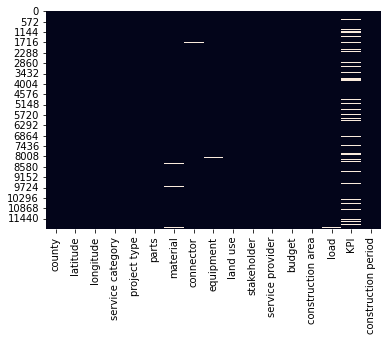

In [403]:
""" Visualize the distribution of the missing values with a Heatmap"""
import seaborn as sns
sns.heatmap(whole_data.isnull(), cbar=False)

In [404]:
""" Correlation with a Heatmap """

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = whole_data.corr()
corr_matrix

,latitude,longitude,budget,construction area,KPI,construction period
latitude,1.000000,-0.707916,-0.042051,0.409197,-0.001597,-0.091152
longitude,-0.707916,1.000000,0.099441,-0.169665,0.013819,0.076899
budget,-0.042051,0.099441,1.000000,0.070789,0.013681,0.010837
construction area,0.409197,-0.169665,0.070789,1.000000,-0.006920,-0.017702
KPI,-0.001597,0.013819,0.013681,-0.006920,1.000000,-0.009028
construction period,-0.091152,0.076899,0.010837,-0.017702,-0.009028,1.000000


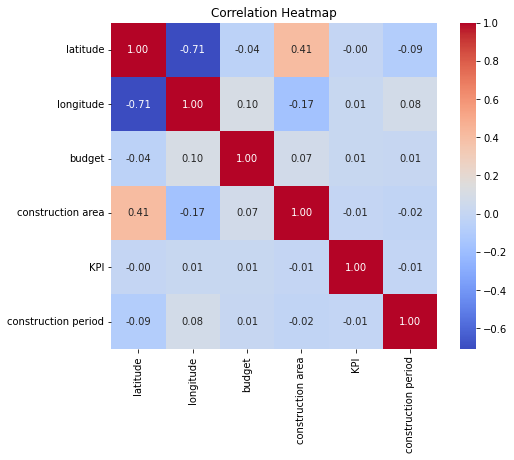

In [405]:
# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.show()

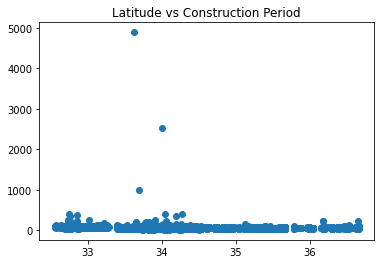

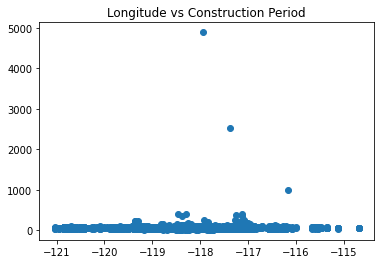

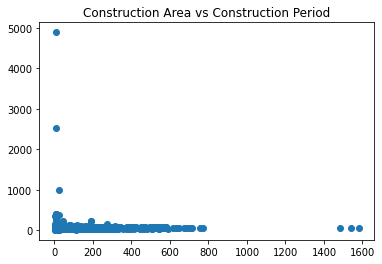

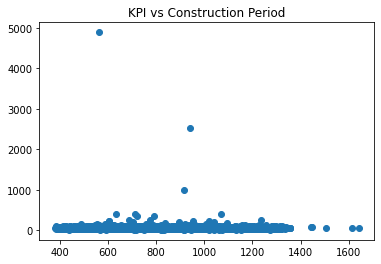

In [406]:
# Scatter plots: Construction Period vs numerical features

import matplotlib.pyplot as plt

plt.title("Latitude vs Construction Period")
plt.scatter(whole_data['latitude'], whole_data['construction period'])
plt.show()
plt.title("Longitude vs Construction Period")
plt.scatter(whole_data['longitude'], whole_data['construction period'])
plt.show()
plt.title("Construction Area vs Construction Period")
plt.scatter(whole_data['construction area'], whole_data['construction period'])
plt.show()
plt.title("KPI vs Construction Period")
plt.scatter(whole_data['KPI'], whole_data['construction period'])
plt.show()

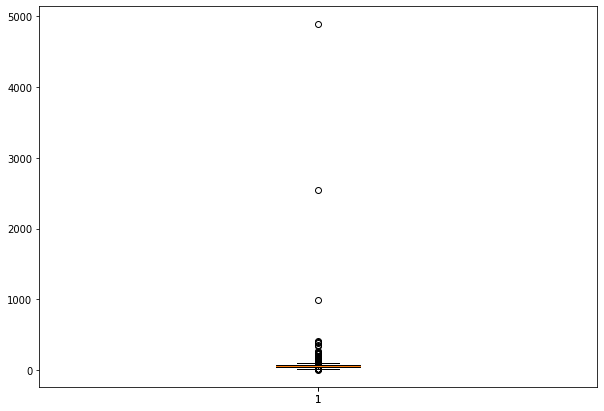

In [407]:
""" A boxplot to confirm sighting of extreme values """

import matplotlib.pyplot as plt
fig = plt.figure(figsize =(10, 7))
 
plt.boxplot(whole_data['construction period'])
plt.boxplot(whole_data['KPI'])
plt.show()

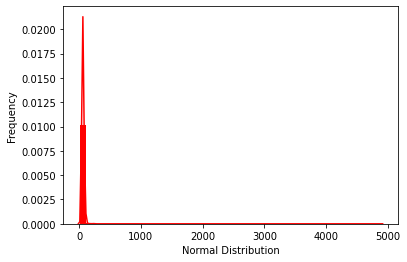

In [408]:
""" Visualize Distribution of the Data """

import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.distplot(whole_data["construction period"],
                  bins=50,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Normal Distribution', ylabel='Frequency')
 
plt.show()

In [409]:
""" Cutting off the dataframe at a point where there would be minimal loss of data to weed out some extreme values """

data = whole_data[whole_data["construction period"] < 120 ]
len(data)

11933

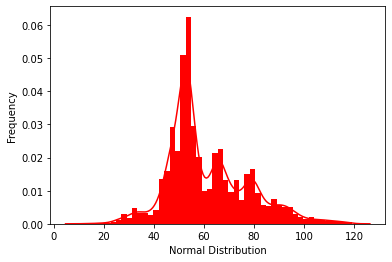

In [410]:
# Updated Distribution of data

import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.distplot(data["construction period"],
                  bins=50,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Normal Distribution', ylabel='Frequency')
 
plt.show()

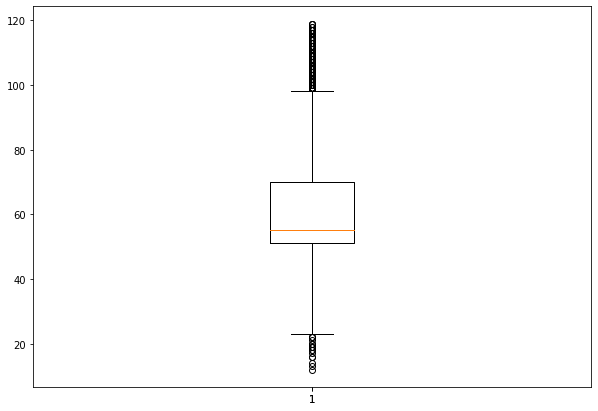

In [411]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(10, 7))
 
plt.boxplot(data['construction period'])
plt.boxplot(data['KPI'])
plt.show()

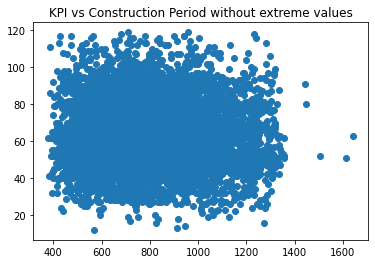

In [412]:
plt.title("KPI vs Construction Period without extreme values")
plt.scatter(data['KPI'], data['construction period'])
plt.show()

In [413]:
#Split data into train and test sets

from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, random_state=500)

**Data Preprocessing**

In [414]:
#Impute missing categorical values with a reasonable value

for col in train:
    if train[col].dtype == 'object':
        train[col] = train[col].replace(np.nan, 'Not Available')

for col in test:
    if test[col].dtype == 'object':
        test[col] = test[col].replace(np.nan, 'Not Available')

In [415]:
""" Set up for one hot encoder, this particular block of code searches through the columns to
find columns which have less than 10 or equal to 10 variables"""
from category_encoders.one_hot import OneHotEncoder
ohe_cat_cols = []
ohe_processed_cols = []
ohe_enc = OneHotEncoder(handle_unknown='ignore', use_cat_names=True)

for col in orig_cat_cols:
    if train[col].nunique() <= 10:
        ohe_cat_cols.append(col)

#Fit OHE
ohe_enc_encoder = ohe_enc.fit(train[ohe_cat_cols])
#Transform using OHE
ohe_train_data_cols = ohe_enc_encoder.transform(train[ohe_cat_cols])
ohe_test_data_cols = ohe_enc_encoder.transform(test[ohe_cat_cols])
#Append the dataframe containing One Hot Encoded columns
train = pd.concat([train, ohe_train_data_cols], axis=1)
test = pd.concat([test, ohe_test_data_cols], axis=1)

""" Target Encoding
This block of code performs roughly the same functions performed for OneHotEncoding,
except it will all be for Target Encoding the features."""

from category_encoders import TargetEncoder
te  = TargetEncoder()
tar_cat_cols = []
for col in train.columns:
    if train[col].dtype == object:
        if train[col].nunique() > 10:
            tar_cat_cols.append(col)
# Fit Target Encoder
tar_enc_encoder = te.fit(train[tar_cat_cols], train['construction period'])
# Transform using Target Encoder
tar_train_encoded_cols =  te.transform(train[tar_cat_cols])
tar_test_encoded_cols = te.transform(test[tar_cat_cols])

# Append Target Encoded columns to train
for col in tar_cat_cols:
    train[col+"_trg"] = tar_train_encoded_cols[col]
for col in tar_cat_cols:
    test[col+"_trg"] = tar_test_encoded_cols[col]
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [416]:
# Regression Imputing missing KPI values.
y_train = train[['KPI']].replace(np.nan, 0)
X_train = train.drop(cols_to_drop, axis=1)

y_test = test[['KPI']].replace(np.nan, 0)
X_test = test.drop(cols_to_drop, axis=1)

In [417]:
# Import and train the Linear model
from sklearn.linear_model import LinearRegression

reg_imputer = LinearRegression()
reg_imputer.fit(X_train, y_train) #fit on train set

#transform both train and test set
tr_pred = pd.DataFrame(reg_imputer.predict(X_train))
te_pred = pd.DataFrame(reg_imputer.predict(X_test))

In [418]:
train['KPI_imp'] = train['KPI'].fillna(tr_pred[0]) #impute train set
test['KPI_imp'] = test['KPI'].fillna(te_pred[0]) #impute test set
# train = train.drop(columns='index')
# test = test.drop(columns='index')
orig_num_cols.remove('KPI') #update list of original numerical columns
orig_num_cols.append('KPI_imp') #update list of original numerical columns

In [419]:
#scaling the data

#note the data is being scaled after regression imputing considering the fact that scaling is not necessary for linear regression

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# #taking care of discrepancies which might have appeared after column transformations
# train = train.fillna(value=0)
# train = train.replace(np.inf, 0)

# Fit the scaler to the selected columns
scaler = scaler.fit(train[orig_num_cols])
scaled_train_cols = scaler.transform(train[orig_num_cols])
scaled_train_cols = pd.DataFrame(scaled_train_cols, columns=orig_num_cols)

scaled_test_cols = scaler.transform(test[orig_num_cols])
scaled_test_cols = pd.DataFrame(scaled_test_cols, columns=orig_num_cols)

# Append scaled columns to the train frame
train = train.reset_index(drop=True)
for col in scaled_train_cols:
    train[col+'_sc'] = scaled_train_cols[col]
    train.drop(col, axis=1)
test = test.reset_index(drop=True)
for col in scaled_test_cols:
    test[col+'_sc'] = scaled_test_cols[col]
    test.drop(col, axis=1)

In [420]:
#update list of columns
cols_to_drop.append('KPI_imp')
cols_to_drop.append('KPI')

#prepare input and target variables
X_train = train.drop(columns=cols_to_drop, axis=1)
X_test = test.drop(columns=cols_to_drop, axis=1)

y_train = train[['construction period']]
y_test = test[['construction period']]

**Model Selection, Training and Evaluation**

    1. Linear Regression
    2. Random Forest Regression
    3. Gradient Boosted Linear Regression
    4. Support Vector Machine
    5. k-NN Regressor



1. Linear Regression

In [421]:
scores = {}

In [422]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X=X_train, y=y_train)
y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)

In [423]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

Train_RMSE = mean_squared_error(y_train, y_train_pred, squared=False)
Test_RMSE = mean_squared_error(y_test, y_test_pred, squared=False)

mape = mean_absolute_percentage_error(y_test, y_pred)

In [424]:
scores['Linear Regression'] = Test_RMSE
print(Train_RMSE, Test_RMSE)
print("MAPE: ", mape)

6.8800062384462555 15.967521896402946
MAPE:  0.09456541707829565


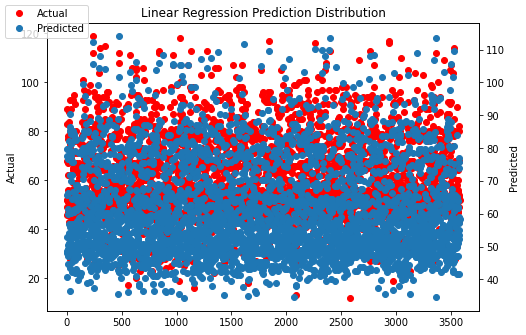

In [425]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.plot(y_test, 'ro')
a1.set_ylabel('Actual')
a2 = a1.twinx()
a2.plot(y_pred,'o')
a2.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper left')
plt.title('Linear Regression Prediction Distribution')
plt.show()

2. RandomForestRegressor

In [426]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rfr = RandomForestRegressor() 
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE: ", rmse)

RMSE:  4.136966823314722


In [297]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

# Create a Random Forest Regression model
model = RandomForestRegressor()

# Define the hyperparameters and their ranges for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search with cross-validation
rfr_grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
rfr_grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = rfr_grid_search.best_estimator_
best_params = rfr_grid_search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Print the best parameters and test results
print("Best parameters:", best_params)
print("Test MSE:", mean_squared_error(y_test, y_pred, squared=False))
scores['Random Forest Regressor'] = mean_squared_error(y_test, y_pred, squared=False)

Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Test MSE: 4.12728677843674


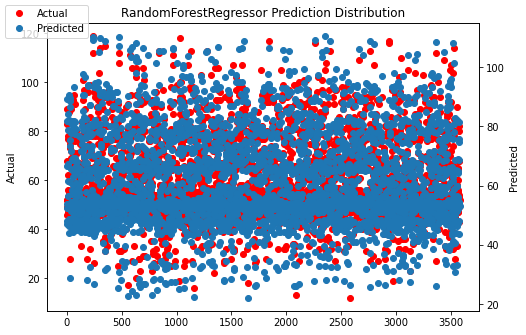

In [298]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.plot(y_test, 'ro')
a1.set_ylabel('Actual')
a2 = a1.twinx()
a2.plot(y_pred,'o')
a2.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper left')
plt.title('RandomForestRegressor Prediction Distribution')
plt.show()

3. GradientBoostingRegressor

In [347]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics  import mean_squared_error, mean_absolute_percentage_error

model = GradientBoostingRegressor(random_state=42)

param_grid = {
    'learning_rate':[0.05, 0.1, 0.15],
    'n_estimators':[100, 200, 500],
    'min_samples_split':[3, 4, 5],
    'min_samples_leaf':[3, 4, 5],
    'max_depth':[3, 5, 7]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gbr_grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
gbr_grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_gbr_model = gbr_grid_search.best_estimator_
best_gbr_params = gbr_grid_search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
scores['Gradient Boosting Estimator'] = rmse
# Print the best parameters and RMSE
print("Best parameters:", best_gbr_params)
print("RMSE:", rmse)
print("MAPE:", mape)

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
RMSE: 3.3897397174658526
MAPE: 0.028952042684365777


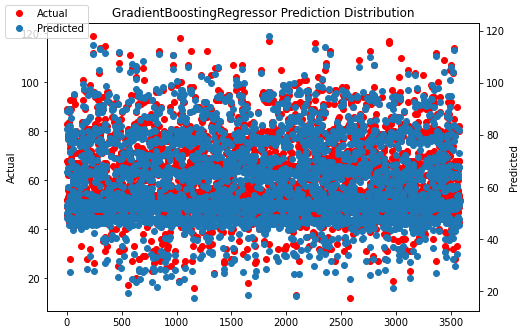

In [300]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.plot(y_test, 'ro')
a1.set_ylabel('Actual')
a2 = a1.twinx()
a2.plot(y_pred,'o')
a2.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper left')
plt.title('GradientBoostingRegressor Prediction Distribution')
plt.show()

4. SupportVectorMachine (SVR)

In [301]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# Create an SVR model with a non-linear kernel (e.g., RBF)
model = SVR(kernel='rbf', C=50, epsilon=0.5, gamma=0.01)

# Fit the model to the data
model.fit(X_train, y_train)

# Generate predictions on a test set
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(rmse, mape)

4.683380482209753 0.04150542173521454


In [302]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Create an SVR model
model = SVR()

# Define the hyperparameters and their ranges for grid search
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.001, 0.01, 1, 10, 20, 50],
    'gamma': ['scale', 'auto']
}

# Perform grid search with cross-validation
svr_grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
svr_grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = svr_grid_search.best_estimator_
best_params = svr_grid_search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Print the best parameters and test results
print("Best parameters:", best_params)
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
scores['Support Vector Machine'] = mean_squared_error(y_test, y_pred, squared=False)

Best parameters: {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
Test RMSE: 5.934114161624632


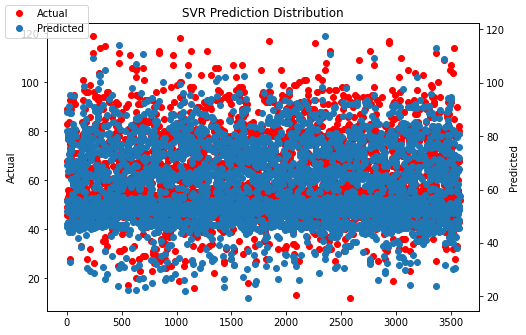

In [303]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.plot(y_test, 'ro')
a1.set_ylabel('Actual')
a2 = a1.twinx()
a2.plot(y_pred,'o')
a2.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper left')
plt.title('SVR Prediction Distribution')
plt.show()

In [304]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Create a KNN Regression model
model = KNeighborsRegressor()

# Define the parameter grid to search
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'leaf_size': [10,20,30],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Perform grid search with cross-validation
knn_grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error')
knn_grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = knn_grid_search.best_estimator_
best_params = knn_grid_search.best_params_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
scores['K Nearest Neighbors'] = rmse

# Print the best parameters and RMSE
print("Best parameters:", best_params)
print("RMSE:", rmse)

Best parameters: {'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
RMSE: 5.676083946891481


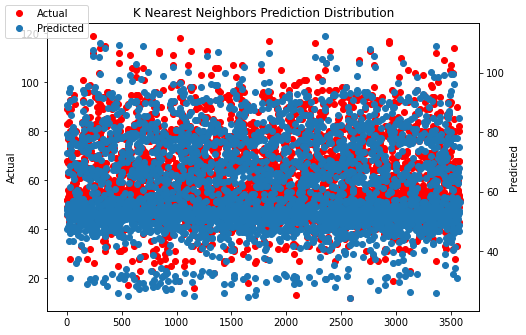

In [305]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.plot(y_test, 'ro')
a1.set_ylabel('Actual')
a2 = a1.twinx()
a2.plot(y_pred,'o')
a2.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper left')
plt.title('K Nearest Neighbors Prediction Distribution')
plt.show()

In [322]:
model_perf = pd.DataFrame(data=scores, index=[0]).transpose()

<BarContainer object of 5 artists>

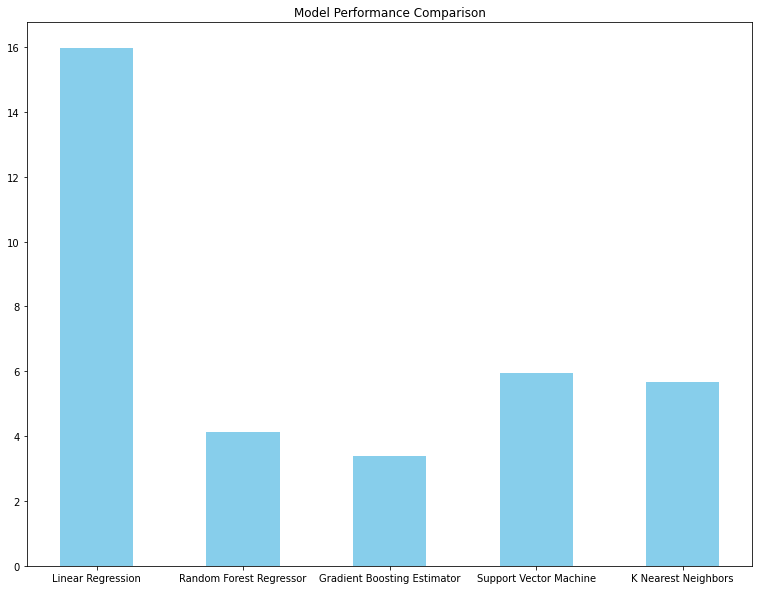

In [592]:
fig=plt.figure(figsize=(13, 10))
plt.title('Model Performance Comparison')
plt.bar(model_perf.index, model_perf[0], color='skyblue', width=0.5)

Observations: GradienBoostingRegressor so far has been able to deliver the lowest RMSE score in the range of ~3.38. The target variable range being investigated is 120 (0 - 120) and a RMSE score would translate into a Mean Absolute Percentage Error of    0.029 which indicates that the predicted values, on average, are within 3% of the actual values.

Considering the observations made from tuning and evaluating the models, GradientBoostingRegressor has been selected as the final model to draw the predictions from.

In [428]:
#Save GBR model with best parameters.
gbr_1 = best_gbr_model

# Prepare another model to train on the entire data
gbr_2 = GradientBoostingRegressor(**gbr_grid_search.best_params_)
dfs = [train, test]
train_full = pd.concat(dfs, axis=0)

gbr_2.fit(train_full.drop(columns=cols_to_drop, axis=1), train_full[['construction period']])

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                          min_samples_split=5, n_estimators=500)

                                                                                                                        End of Model Evaluation

                                                                                                                                ....

**Predicting construction period**

    Step: Regressing over holdout data to predict construction durations

In [429]:
df = pd.read_csv('- Construction Portfolio.csv')

In [586]:
""" Creating a scoring function suitable for reuse or packaging"""

def predict_construction_duration(df):


    test = df

    for col in test:
        if test[col].dtype == 'object':
            test[col] = test[col].replace(np.nan, 'Not Available')

    for col in cols_to_drop:
        if col == 'KPI_imp':
            cols_to_drop.remove(col)
        if col == 'construction period':
            cols_to_drop.remove(col)

    ohe_test_data_cols = ohe_enc_encoder.transform(test[ohe_cat_cols])
    test = pd.concat([test, ohe_test_data_cols], axis=1)
    tar_test_encoded_cols = te.transform(test[tar_cat_cols])

    for col in tar_cat_cols:
        test[col+"_trg"] = tar_test_encoded_cols[col]

    cols_to_drop.append('index')
    X_t = test.drop(columns=cols_to_drop, axis=1)
    y_t = test[['KPI']].replace(np.nan, 0)

    lr_imputer = LinearRegression()
    lr_imputer.fit(X_t, y_t)
    te_pred = pd.DataFrame(reg_imputer.predict(X_t))

    test['KPI_imp'] = test['KPI'].fillna(te_pred[0])

    scaled_test_cols = scaler.transform(test[orig_num_cols])
    scaled_test_cols = pd.DataFrame(scaled_test_cols, columns=orig_num_cols)

    for col in scaled_test_cols:
        test[col+'_sc'] = scaled_test_cols[col]
        test.drop(col, axis=1)

    cols_to_drop.append('KPI_imp')
    cols_to_drop.append('KPI')

    test_test = test.drop(columns=cols_to_drop, axis=1)

    test['prediction_1'] = gbr_1.predict(test_test)
    test['prediction_2'] = gbr_2.predict(test_test)

    return test

In [587]:
# Use the function to append the predictions to the 'test' dataset
test = predict_construction_duration(df)

In [440]:
# Edit the Results file to write the Predicted data on to it.

infile = pd.read_csv('- Construction Results.csv')
infile['prediction_1'] = test['prediction_1']
infile['prediction_2'] = test['prediction_2']

infile.to_csv('- Construction Results.csv') #Save changes by overwriting the original file

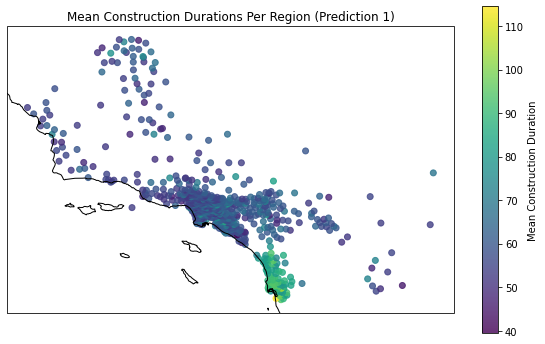

In [526]:
import matplotlib.pyplot as plt
import geopandas as gpd
from cartopy.io.shapereader import Reader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Load the shapefile for region boundaries and labels :: File downloaded from ca.gov
shap = '/Users/tanmaybirar/Downloads/CA_Counties/CA_Counties_TIGER2016.shp' 
regions = gpd.read_file(shap)

# Group data by region and calculate mean construction durations (prediction_1 columns)
mean_cons = test.groupby(['latitude', 'longitude'])['prediction_1'].mean().reset_index()

# Create a map plot
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
    
# Plot the mean construction durations as scatter points
sc = ax.scatter(mean_cons['longitude'], mean_sales['latitude'], c=mean_cons['prediction_1'], cmap='viridis', transform=ccrs.PlateCarree(), alpha=0.8)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Mean Construction Duration')

# Add map features
ax.coastlines()
ax.add_geometries(regions['geometry'], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.8)

ax.set_title('Mean Construction Durations Per Region (Prediction 1)')


plt.show()

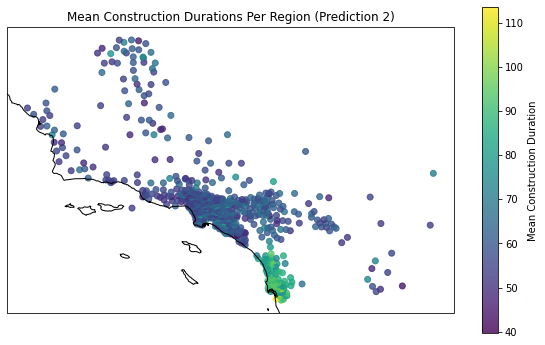

In [528]:
import matplotlib.pyplot as plt
import geopandas as gpd
from cartopy.io.shapereader import Reader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Load the shapefile for region boundaries and labels
shap = '/Users/tanmaybirar/Downloads/CA_Counties/CA_Counties_TIGER2016.shp'
regions = gpd.read_file(shap)

# Group data by region and calculate mean sales value
mean_cons = test.groupby(['latitude', 'longitude'])['prediction_2'].mean().reset_index()

# Create a map plot
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
    
# Plot the mean construction durations as scatter points
sc = ax.scatter(mean_cons['longitude'], mean_sales['latitude'], c=mean_cons['prediction_2'], cmap='viridis', transform=ccrs.PlateCarree(), alpha=0.8)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Mean Construction Duration')

# Add map features
ax.coastlines()
ax.add_geometries(regions['geometry'], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.8)

ax.set_title('Mean Construction Durations Per Region (Prediction 2)')


plt.show()

<BarContainer object of 5 artists>

<Figure size 2880x432 with 0 Axes>

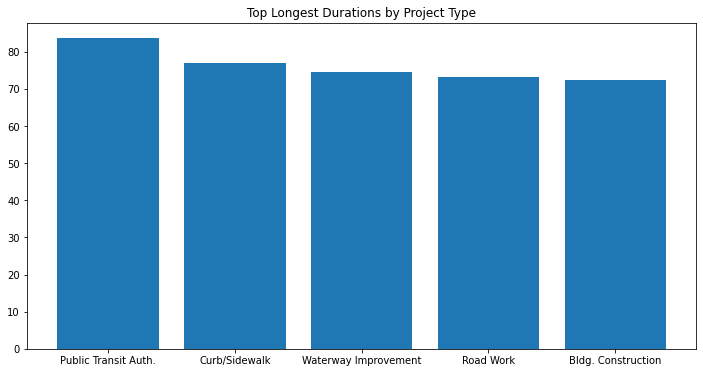

In [582]:
mean_pro = test.groupby(['project type'])['prediction_1'].mean().reset_index()
plt.figure(figsize=(40,6))
mean_pro = mean_pro.sort_values(by=['prediction_1'], ascending=False)
plt.figure(figsize=[12,6])
plt.title("Top Longest Durations by Project Type")
plt.bar(mean_pro['project type'][0:5],mean_pro['prediction_1'][0:5])

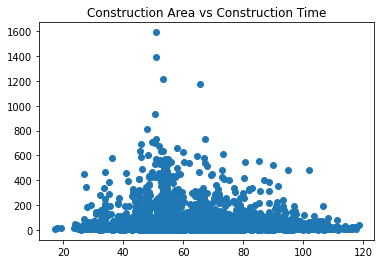

In [584]:
plt.title("Construction Area vs Construction Time")
plt.scatter(test['prediction_1'], test['construction area'])

<BarContainer object of 5 artists>

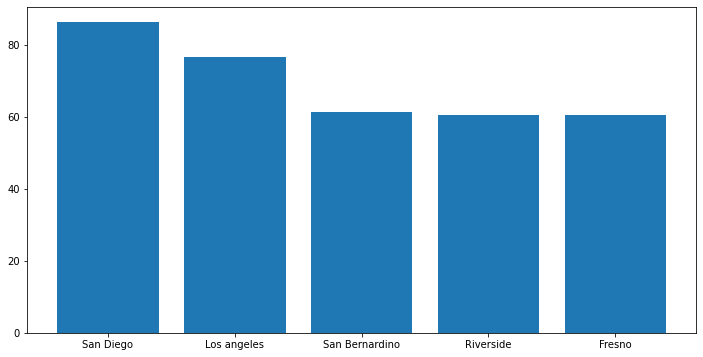

In [576]:
mean_loc_area = test.groupby(['county'])['construction area', 'prediction_1'].mean().reset_index()
mean_loc_area = mean_loc_area.sort_values(by=['prediction_1'], ascending=False)
plt.figure(figsize=[12,6])
plt.title("Counties with Longest Durations (Mean)")
plt.bar(mean_loc_area['county'][0:5],mean_loc_area['prediction_1'][0:5])